Importing the necessary libraries

In [229]:
import pandas as pd
import os
import librosa
import librosa.display
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import os
from scipy.io import wavfile
import seaborn as sns
from tensorflow.keras.layers import LSTM
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from sklearn.model_selection import train_test_split
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
import noisereduce as nr
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
import tensorflow.keras as keras

Loading audio files

In [2]:
# Loading healthy 
normal=os.listdir("heart_sound/healthy")[:650]

# Loading unhealthy
abnormal=os.listdir("heart_sound/unhealthy")

In [4]:
normal_sounds=[]
normal_duration=[]
sample_rate=22050
for sound in normal:
    audio, sample_rate = librosa.load(os.path.join("heart_sound/healthy/"+sound),sr=sample_rate,mono=True, res_type='kaiser_fast')
    normal_sounds.append(audio)
    normal_duration.append(librosa.core.get_duration(audio,sample_rate))

In [5]:
normal_df= pd.DataFrame()
normal_df['audio']= normal_sounds
normal_df['class']= 0
normal_df['file_name']=normal
normal_df['duration']=normal_duration

In [6]:
abnormal_sounds=[]
abnormal_duration=[]
for sound in abnormal:
    audio, sample_rate = librosa.load(os.path.join("heart_sound/unhealthy/"+sound),sr=sample_rate,mono=True, res_type='kaiser_fast')
    abnormal_sounds.append(audio)
    abnormal_duration.append(librosa.core.get_duration(audio,sample_rate))

In [7]:
abnormal_df= pd.DataFrame()
abnormal_df['audio']= abnormal_sounds
abnormal_df['class']= 1
abnormal_df['file_name']=abnormal
abnormal_df['duration']=abnormal_duration

In [8]:
heart_sound= pd.concat([normal_df, abnormal_df], ignore_index=True, sort=False)

In [9]:
heart_sound.shape

(1315, 4)

In [10]:
heart_sound.head()

,audio,class,file_name,duration
0,"[0.0010432453, 0.0014091895, 0.0018182063, 0.0...",0,b0123.wav,8.000000
1,"[-0.090585805, -0.09565477, -0.099753596, -0.1...",0,e01947.wav,8.119002
2,"[-0.0010384485, -0.0014539795, -0.0018792074, ...",0,e00481.wav,17.966032
3,"[0.004732245, 0.0044500255, 0.0040681735, 0.00...",0,e00495.wav,15.101043
4,"[-0.012747022, -0.0134038385, -0.013926082, -0...",0,e01006.wav,20.381043


### EDA

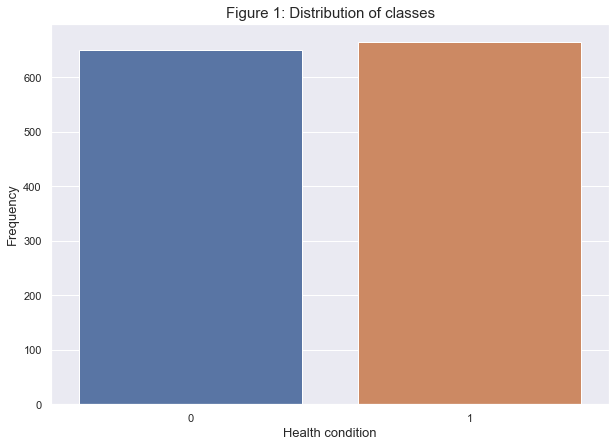

In [11]:
sns.set(rc={'figure.figsize':(10,7)})
ax = sns.countplot(x="class",data=heart_sound);
ax.set_xlabel("Health condition",fontsize=13);
ax.set_ylabel("Frequency",fontsize=13);
ax.set_title('Figure 1: Distribution of classes',fontsize=15);
plt.savefig('images/Figure1.png', dpi=200)

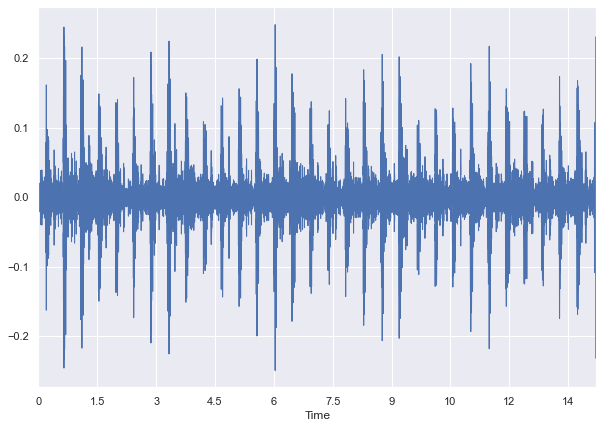

In [12]:
librosa.display.waveplot(heart_sound['audio'][10],sr=sample_rate)
ipd.Audio(heart_sound['audio'][10],rate=sample_rate)

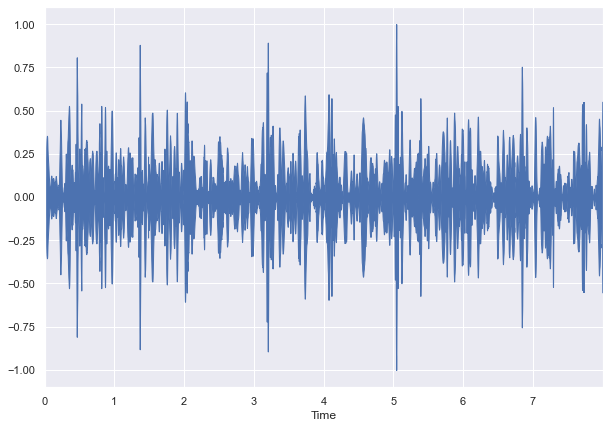

In [13]:
librosa.display.waveplot(heart_sound['audio'][1002],sr=sample_rate)
ipd.Audio(heart_sound['audio'][1002],rate=sample_rate)

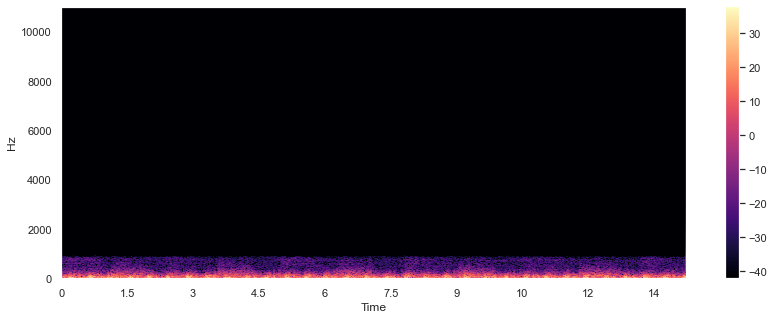

In [14]:
X = librosa.stft(heart_sound['audio'][10]) #fourier transform
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz') 
plt.colorbar()

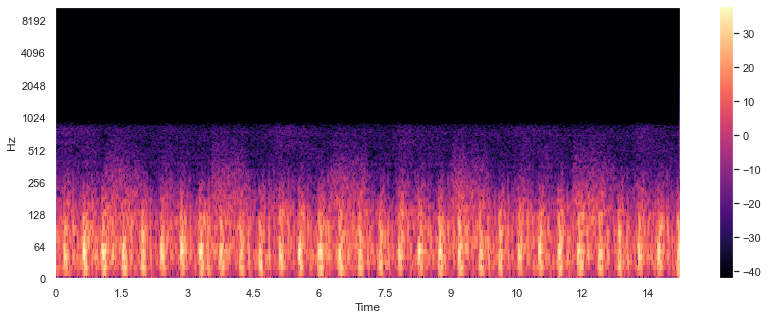

In [15]:
X = librosa.stft(heart_sound['audio'][10]) #fourier transform
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='log') 
plt.colorbar()

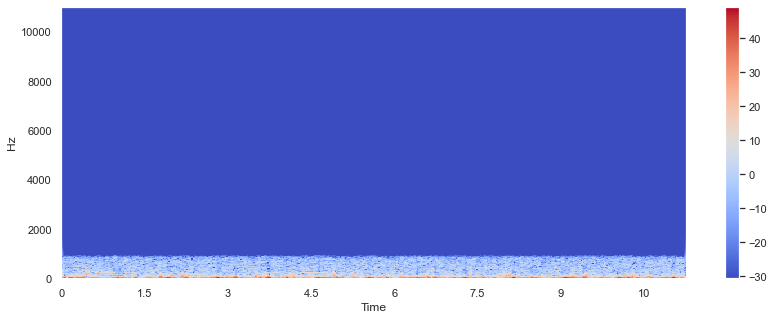

In [16]:
X = librosa.stft(heart_sound['audio'][1000]) #fourier transform
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz') 
plt.colorbar()

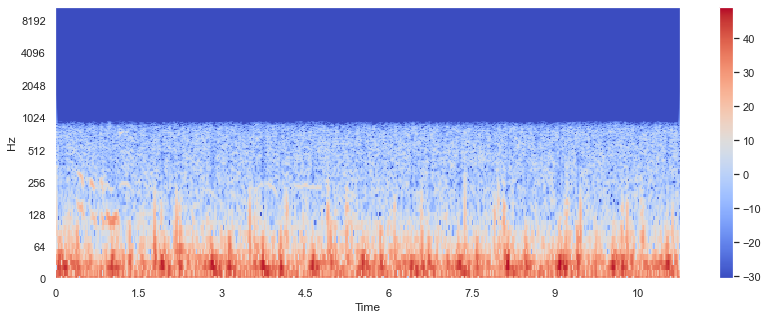

In [17]:
X = librosa.stft(heart_sound['audio'][1000]) #fourier transform
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='log') 
plt.colorbar()

### Determine the most relevant metric(s)

Recall

### Classification Baseline

In [18]:
def features_extractor(audio, sample_rate):
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features

In [54]:
extracted_features=[]
for audio in heart_sound['audio']:
        data=features_extractor(audio,22050)
        extracted_features.append(data)

In [55]:
heart_sound['extracted_features']=extracted_features

In [56]:
x=np.array(heart_sound['extracted_features'].tolist())
y=np.array(heart_sound['class'].tolist())

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

knn = KNeighborsClassifier(n_neighbors=70)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=70)

In [57]:
print(knn.score(X_val,y_val))

0.7104247104247104


In [58]:
y_pred=knn.predict(X_test)
recall_score(y_test, y_pred, average='macro')

0.7301373954599761

### Preprocessing

Checking the length of audio files

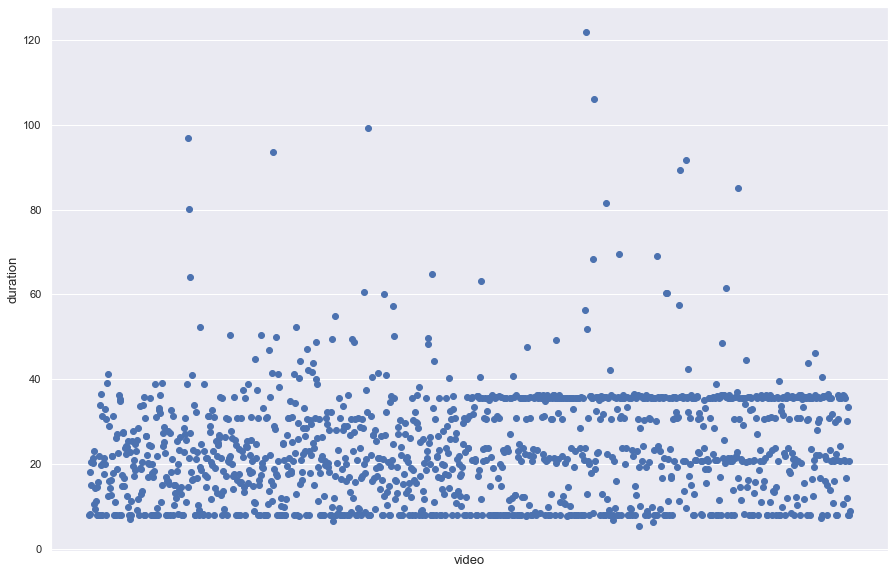

In [30]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)
video = heart_sound['file_name']
duration = heart_sound['duration']
plt.xlabel("video",fontsize=13);
plt.ylabel("duration",fontsize=13);
plt.xticks([])
plt.scatter(video,duration)
plt.show()

Removing audio files of 90 seconds or more

In [91]:
heart_sound=heart_sound[heart_sound['duration']<40]

In [92]:
len(heart_sound['audio'][0])

176400

In [93]:
heart_sound['duration'][0]

8.0

Removing noise

In [94]:
def reducenoise(audio):
    return nr.reduce_noise(y=audio, sr=44100)

In [95]:
heart_sound['audio']=heart_sound['audio'].apply(lambda x:reducenoise(x))

KeyboardInterrupt: 

making all audio files the same length

In [96]:
heart_sound=heart_sound.reset_index(drop=True)
max1 = len(heart_sound['audio'][0])
for i in range(len(heart_sound)):
    if max1< len(heart_sound['audio'][i]):
        max1=len(heart_sound['audio'][i])
print(max1)

872122


In [97]:
audio_padded=[]
for i in range(len(heart_sound)):
    n=max1-len(heart_sound['audio'][i])
    newdf=np.pad(heart_sound['audio'][i],(0,n),'constant')
    audio_padded.append(newdf)

In [98]:
heart_sound['audio_padded']=audio_padded

# Neural Networks

## Simple Neual Network

Extracting features

In [106]:
extracted_features=[]
for audio in heart_sound['audio']:
        data=features_extractor(audio,22050)
        extracted_features.append(data)

In [107]:
heart_sound['extracted_features']=extracted_features

In [182]:
x=np.array(heart_sound['extracted_features'].tolist())
y=np.array(heart_sound['class'].tolist())

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

Building the network

In [180]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [200]:
ann_model=Sequential()
ann_model.add(Dense(100,input_shape=(40,)))
ann_model.add(Activation('tanh'))
ann_model.add(Dropout(0.5))

ann_model.add(Dense(200))
ann_model.add(Activation('tanh'))
ann_model.add(Dropout(0.5))

ann_model.add(Dense(100))
ann_model.add(Activation('tanh'))
ann_model.add(Dropout(0.5))

ann_model.add(Dense(1))
ann_model.add(Activation('sigmoid'))

In [206]:
ann_model.compile(loss='binary_crossentropy',metrics=['acc',f1_m,precision_m, recall_m],optimizer='adam')

In [207]:
num_epochs = 40
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification1.hdf5', verbose=1, save_best_only=True)
start = datetime.now()

ann_model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/40
 1/28 [>.............................] - ETA: 17s - loss: 0.5262 - acc: 0.7500 - f1_m: 0.8000 - precision_m: 0.7273 - recall_m: 0.8889
Epoch 00001: val_loss improved from inf to 0.45206, saving model to saved_models/audio_classification1.hdf5
28/28 [==============================] - 1s 11ms/step - loss: 0.5341 - acc: 0.7282 - f1_m: 0.7351 - precision_m: 0.7089 - recall_m: 0.7716 - val_loss: 0.4521 - val_acc: 0.7968 - val_f1_m: 0.8118 - val_precision_m: 0.7294 - val_recall_m: 0.9372
Epoch 2/40
 1/28 [>.............................] - ETA: 0s - loss: 0.5317 - acc: 0.7500 - f1_m: 0.7647 - precision_m: 0.8667 - recall_m: 0.6842
Epoch 00002: val_loss did not improve from 0.45206
28/28 [==============================] - 0s 3ms/step - loss: 0.5754 - acc: 0.7087 - f1_m: 0.7115 - precision_m: 0.6834 - recall_m: 0.7768 - val_loss: 0.4727 - val_acc: 0.7914 - val_f1_m: 0.8157 - val_precision_m: 0.7076 - val_recall_m: 0.9798
Epoch 3/40
 1/28 [>.............................] - ETA: 0s - l

22/28 [======================>.......] - ETA: 0s - loss: 0.5439 - acc: 0.7145 - f1_m: 0.7253 - precision_m: 0.6965 - recall_m: 0.7761
Epoch 00019: val_loss did not improve from 0.43845
28/28 [==============================] - 0s 4ms/step - loss: 0.5411 - acc: 0.7179 - f1_m: 0.7416 - precision_m: 0.7088 - recall_m: 0.7960 - val_loss: 0.4740 - val_acc: 0.7807 - val_f1_m: 0.8085 - val_precision_m: 0.6965 - val_recall_m: 0.9798
Epoch 20/40
25/28 [=========================>....] - ETA: 0s - loss: 0.5271 - acc: 0.7462 - f1_m: 0.7769 - precision_m: 0.7077 - recall_m: 0.8855
Epoch 00020: val_loss did not improve from 0.43845
28/28 [==============================] - 0s 4ms/step - loss: 0.5232 - acc: 0.7466 - f1_m: 0.7836 - precision_m: 0.7152 - recall_m: 0.8894 - val_loss: 0.4765 - val_acc: 0.7647 - val_f1_m: 0.7996 - val_precision_m: 0.6723 - val_recall_m: 1.0000
Epoch 21/40
25/28 [=========================>....] - ETA: 0s - loss: 0.5089 - acc: 0.7325 - f1_m: 0.7542 - precision_m: 0.7044 - rec

Epoch 38/40
22/28 [======================>.......] - ETA: 0s - loss: 0.5031 - acc: 0.7557 - f1_m: 0.7862 - precision_m: 0.7057 - recall_m: 0.9018
Epoch 00038: val_loss did not improve from 0.43845
28/28 [==============================] - 0s 4ms/step - loss: 0.5039 - acc: 0.7523 - f1_m: 0.7767 - precision_m: 0.6920 - recall_m: 0.9007 - val_loss: 0.4499 - val_acc: 0.7968 - val_f1_m: 0.8199 - val_precision_m: 0.7137 - val_recall_m: 0.9798
Epoch 39/40
23/28 [=======================>......] - ETA: 0s - loss: 0.5064 - acc: 0.7432 - f1_m: 0.7616 - precision_m: 0.7207 - recall_m: 0.8214
Epoch 00039: val_loss did not improve from 0.43845
28/28 [==============================] - 0s 4ms/step - loss: 0.5148 - acc: 0.7362 - f1_m: 0.7614 - precision_m: 0.7170 - recall_m: 0.8266 - val_loss: 0.4693 - val_acc: 0.7701 - val_f1_m: 0.8031 - val_precision_m: 0.6847 - val_recall_m: 0.9902
Epoch 40/40
24/28 [========================>.....] - ETA: 0s - loss: 0.5092 - acc: 0.7435 - f1_m: 0.7801 - precision_m: 

In [203]:
loss, accuracy, f1_score, precision, recall = ann_model.evaluate(X_test,y_test, verbose=0)

In [205]:
recall

0.9426345825195312

In [197]:
test_accuracy=ann_model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.4680851101875305


## LSTM Neural Network

In [208]:
n_mfcc=13
n_ftt=2048
hop_length=512
mfcc_abnormal={'mfcc':[]}
samples_per_track = sample_rate * 40
num_segment=15
samples_per_segment = int(samples_per_track / num_segment)
num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

heart_sound_ab=heart_sound[heart_sound['class']==1]
for sound in heart_sound_ab['audio_padded']:
    for s in range(num_segment):
        start = samples_per_segment * s
        finish = start + samples_per_segment
        print(start)
        print(finish)
        mfcc= librosa.feature.mfcc(y=sound[start:finish], sr=sample_rate, n_mfcc=13, n_fft=2048, hop_length=512)
        mfcc=mfcc.T
        if len(mfcc) == num_mfcc_vectors_per_segment:
            mfcc_abnormal['mfcc'].append(mfcc.tolist())  

abnormal_features=pd.DataFrame.from_dict(mfcc_abnormal)
abnormal_features['class']=1

0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200

588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200

176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600

0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200

294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200

411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800

294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200

470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600

646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000

529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400

529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400

352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000

588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200

176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600

117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
5880

646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000
588000
646800
646800
705600
705600
764400
764400
823200
823200
882000
0
58800
58800
117600
117600
176400
176400
235200
235200
294000
294000
352800
352800
411600
411600
470400
470400
529200
529200
588000

In [209]:
mfcc_normal={'mfcc':[]}
heart_sound_an=heart_sound[heart_sound['class']==0]
for sound in heart_sound_an['audio_padded']:
    for s in range(num_segment):
        start = samples_per_segment * s
        finish = start + samples_per_segment
        mfcc= librosa.feature.mfcc(y=sound[start:finish], sr=sample_rate, n_mfcc=13, n_fft=2048, hop_length=512)
        mfcc=mfcc.T
        if len(mfcc) == num_mfcc_vectors_per_segment:
            mfcc_normal['mfcc'].append(mfcc.tolist())  

normal_features=pd.DataFrame.from_dict(mfcc_abnormal)
normal_features['class']=0

In [210]:
heart_sound_LSTM= pd.concat([abnormal_features, normal_features], ignore_index=True, sort=False)

In [211]:
X2=np.array(heart_sound_LSTM['mfcc'].tolist())
y2=np.array(heart_sound_LSTM['class'].tolist())

In [212]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.4, random_state=42)
X_val2, X_test2, y_val2, y_test2 = train_test_split(X_test2, y_test2, test_size=0.5, random_state=42)

In [213]:
input_shape = (X_train2.shape[1],X_train2.shape[2])

Building the network

In [214]:
lstm_model=Sequential()
lstm_model.add(keras.layers.LSTM(64,input_shape = (input_shape),return_sequences=True))
lstm_model.add(keras.layers.LSTM(64))
lstm_model.add(keras.layers.Dense(64, activation='relu'))
lstm_model.add(keras.layers.Dropout(0.3))
lstm_model.add(keras.layers.Dense(64, activation='relu'))
lstm_model.add(keras.layers.Dropout(0.3))
lstm_model.add(keras.layers.Dense(1, activation='sigmoid'))
lstm_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 115, 64)           19968     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_52 (Dense)            (None, 64)                4160      
                                                                 
 dropout_38 (Dropout)        (None, 64)                0         
                                                                 
 dense_53 (Dense)            (None, 64)                4160      
                                                                 
 dropout_39 (Dropout)        (None, 64)                0         
                                                                 
 dense_54 (Dense)            (None, 1)               

In [217]:
lstm_model.compile(loss='binary_crossentropy',metrics=['acc',f1_m,precision_m, recall_m],optimizer='adam')

In [216]:
num_epochs = 30
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification2.hdf5',
                               verbose=1, save_best_only=True)

start = datetime.now()
lstm_model.fit(X_train2, y_train2, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_val2, y_val2), callbacks=[checkpointer], verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/30
 65/335 [====>.........................] - ETA: 19s - loss: 0.6974 - accuracy: 0.4846

KeyboardInterrupt: 

In [239]:
loss, accuracy, f1_score, precision, recall = lstm_model.evaluate(X_test,y_test, verbose=0)

ValueError: in user code:

    File "/Users/reefalturki/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1366, in test_function  *
        return step_function(self, iterator)
    File "/Users/reefalturki/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1356, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/reefalturki/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1349, in run_step  **
        outputs = model.test_step(data)
    File "/Users/reefalturki/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1303, in test_step
        y_pred = self(x, training=False)
    File "/Users/reefalturki/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/reefalturki/.local/lib/python3.8/site-packages/keras/engine/input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_14" is incompatible with the layer: expected shape=(None, 115, 13), found shape=(None, 40)


### CNN 

In [227]:
INPUT_DIR ="heart_sound/"
OUTPUT_DIR = 'spectograms/'

def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

if not os.path.exists(os.path.join(OUTPUT_DIR, 'audio-images')):
    os.mkdir(os.path.join(OUTPUT_DIR, 'audio-images'))

In [228]:
cls=0

for dirr in os.listdir(INPUT_DIR):
    c=1
    print(dirr)
    for filename in os.listdir(INPUT_DIR+dirr+"/"):
        if "wav" in filename:
            if c == 650:
                break
            c+=1
            file_path = os.path.join(INPUT_DIR+dirr+"", filename)
            file_stem = Path(file_path).stem
            target_dir = "class_"+str(cls)
            dist_dir = os.path.join(os.path.join(OUTPUT_DIR, 'audio-images'), target_dir)
            file_dist_path = os.path.join(dist_dir, file_stem)
            if not os.path.exists(file_dist_path + '.png'):
                if not os.path.exists(dist_dir):
                    os.mkdir(dist_dir)
                file_stem = Path(file_path).stem
                sound_info, frame_rate = get_wav_info(file_path)
                pylab.specgram(sound_info, Fs=frame_rate)
                pylab.savefig(f'{file_dist_path}.png')
                pylab.close()
    cls+=1
# Print the ten classes in our dataset
path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images'))
print("Classes: \n")
for i in range(2):
    print(path_list[i])
# File names for class 1
path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images/class_1'))
print("\nA few example files: \n")
for i in range(10):
    print(path_list[i])

healthy
unhealthy
.ipynb_checkpoints
Classes: 

class_0
class_1

A few example files: 

e01661.png
a0122.png
b0022.png
e01846.png
a0320.png
a0308.png
c0027.png
b0208.png
b0397.png
a0254.png


In [230]:
# Declare constants
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 10
# Make a dataset containing the training spectrograms
train_dataset = keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(OUTPUT_DIR, 'audio-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="training",
                                             seed=0)
# Make a dataset containing the validation spectrogram
valid_dataset = keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(OUTPUT_DIR, 'audio-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=0)

Found 1298 files belonging to 2 classes.
Using 1039 files for training.
Found 1298 files belonging to 2 classes.
Using 259 files for validation.


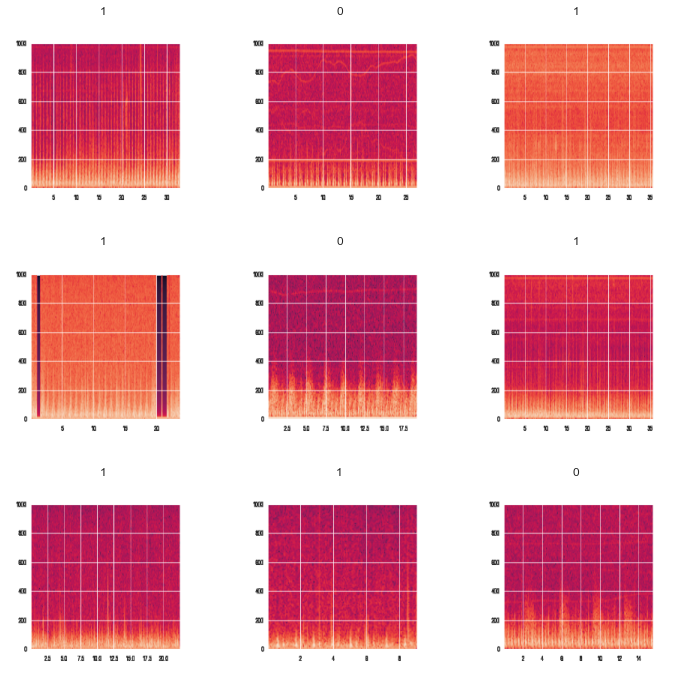

In [233]:
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.show()

In [234]:
# Function to prepare our datasets for modelling
def prepare(ds, augment=False):
    # Define our one transformation
    rescale = keras.Sequential([keras.layers.experimental.preprocessing.Rescaling(1./255)])
    flip_and_rotate = keras.Sequential([
        keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        keras.layers.experimental.preprocessing.RandomRotation(0.2)
    ])
    # Apply rescale to both datasets and augmentation only to training
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    if augment: ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return ds
train_dataset = prepare(train_dataset, augment=False)
valid_dataset = prepare(valid_dataset, augment=False)

In [235]:
# Create CNN model
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
model.add(keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [236]:
# Compile model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc',f1_m,precision_m, recall_m],)

In [237]:
results = model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

Epoch 1/10
33/33 [==============================] - 20s 532ms/step - loss: 0.5935 - acc: 0.7603 - f1_m: 0.7574 - precision_m: 0.7601 - recall_m: 0.7725 - val_loss: 1.3977 - val_acc: 0.5174 - val_f1_m: 0.6591 - val_precision_m: 0.4988 - val_recall_m: 1.0000
Epoch 2/10
33/33 [==============================] - 18s 532ms/step - loss: 0.4125 - acc: 0.8239 - f1_m: 0.8179 - precision_m: 0.8216 - recall_m: 0.8226 - val_loss: 0.6398 - val_acc: 0.7606 - val_f1_m: 0.7722 - val_precision_m: 0.6962 - val_recall_m: 0.8842
Epoch 3/10
33/33 [==============================] - 21s 618ms/step - loss: 0.3484 - acc: 0.8614 - f1_m: 0.8578 - precision_m: 0.8401 - recall_m: 0.8870 - val_loss: 0.6423 - val_acc: 0.6255 - val_f1_m: 0.7313 - val_precision_m: 0.5871 - val_recall_m: 0.9865
Epoch 4/10
33/33 [==============================] - 19s 567ms/step - loss: 0.2977 - acc: 0.8864 - f1_m: 0.8854 - precision_m: 0.8742 - recall_m: 0.9077 - val_loss: 1.1248 - val_acc: 0.4865 - val_f1_m: 0.0185 - val_precision_m: 0.

In [ ]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test,y_test, verbose=0)